We will work on this notebook to implement the algorithm.
Please check regularly for updates.

Main tasks:
1. Write the code for the algorithm
2. Find better $\alpha$ and $\beta$ values for the model.
3. Find stopping criteria for the model.
4. Apply the new hyperparameters to the algorithm, and evaluate the results on a lexical similarity task, then on a sentiment analysis task.

In [1]:
# Importing the libraries:
import numpy as np
import gensim.models.word2vec as w2v
import gensim.downloader as api
import math
import re
from copy import deepcopy
import sys
import gzip
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt


In [2]:
# Toy corpus of 10 words:
toy_corpus = ['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect']

In [3]:
# Load the word2vec model:
wv = api.load('word2vec-google-news-300')
#wv = w2v.Word2Vec(vector_size=250, min_count=500, window=8, sample=1e-3, workers=8, sg=1, hs=0, negative=10, epochs=5)

In [4]:
# Vectorize the toy corpus:
#vec_toy_corpus = [wv.wv[word] for word in toy_corpus]
vec_toy_corpus = [wv[word] for word in toy_corpus]

In [5]:
# Compare vectors using cosine similarity:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute the cosine similarity matrix:
similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        similarity_matrix[i][j] = cosine_similarity(vec_toy_corpus[i], vec_toy_corpus[j])

# Print the cosine similarity matrix:
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        print(f'Similarity between {toy_corpus[i]} and {toy_corpus[j]} is {similarity_matrix[i][j]:.4f}')

Similarity between frog and frog is 1.0000
Similarity between frog and toad is 0.7050
Similarity between frog and berger is 0.1045
Similarity between frog and cat is 0.4789
Similarity between frog and cheetah is 0.4109
Similarity between frog and dog is 0.3550
Similarity between frog and feline is 0.3681
Similarity between frog and true is 0.1128
Similarity between frog and false is -0.0008
Similarity between frog and incorrect is 0.0589
Similarity between toad and frog is 0.7050
Similarity between toad and toad is 1.0000
Similarity between toad and berger is 0.1365
Similarity between toad and cat is 0.4725
Similarity between toad and cheetah is 0.4156
Similarity between toad and dog is 0.3837
Similarity between toad and feline is 0.4253
Similarity between toad and true is 0.0903
Similarity between toad and false is 0.0358
Similarity between toad and incorrect is 0.0119
Similarity between berger and frog is 0.1045
Similarity between berger and toad is 0.1365
Similarity between berger a

In [6]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters, alpha = 1, beta = 2): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha*numNeighbours
      newVec = alpha * wordVecs[word] * numNeighbours
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += beta * newWordVecs[ppWord] 
      newWordVecs[word] = newVec/(alpha*numNeighbours + beta) 
  return newWordVecs

In [7]:
# Transform the toy corpus into a wordVecs dictionary:
toy_wordVecs = {}
for i in range(len(vec_toy_corpus)):
    toy_wordVecs[toy_corpus[i]] = vec_toy_corpus[i]
print(toy_wordVecs.keys())

dict_keys(['frog', 'toad', 'berger', 'cat', 'cheetah', 'dog', 'feline', 'true', 'false', 'incorrect'])


In [8]:
# Read the lexicon. We can use NLTK WordNet.
lexicon = {}
# The idea is to create a dictionary where the keys are the words in the corpus
# and the values are the words that are related to the key word from the WordNet.
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in lexicon:
            lexicon[word] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word != word:
                    lexicon[word].append(related_word)


In [9]:
# We can take a peek at the lexicon too:
print(lexicon['cat'])

['domestic_cat', 'house_cat', 'Felis_domesticus', 'Felis_catus', 'wildcat', 'feline', 'felid', 'cheetah', 'chetah', 'Acinonyx_jubatus', 'jaguar', 'panther', 'Panthera_onca', 'Felis_onca', 'leopard', 'Panthera_pardus', 'liger', 'lion', 'king_of_beasts', 'Panthera_leo', 'saber-toothed_tiger', 'sabertooth', 'snow_leopard', 'ounce', 'Panthera_uncia', 'tiger', 'Panthera_tigris', 'tiglon', 'tigon', 'feline', 'felid', 'Felidae', 'family_Felidae', 'tracked_vehicle', 'whip', 'stimulant', 'stimulant_drug', 'excitant', 'gossip', 'gossiper', 'gossipmonger', 'rumormonger', 'rumourmonger', 'newsmonger', 'woman', 'adult_female', 'sod', 'man', 'adult_male', 'excrete', 'egest', 'eliminate', 'pass', 'flog', 'welt', 'whip', 'lather', 'lash', 'slash', 'strap', 'trounce']


In [10]:
# Retrofit the word vectors using basic hyperparameters:
newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = 2)

# Similarity matrix after retrofitting:
retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
        
# Print the cosine similarity matrix:
for i in range(len(vec_toy_corpus)):
    for j in range(len(vec_toy_corpus)):
        print(f'Similarity is changed by {retro_similarity_matrix[i][j] - similarity_matrix[i][j]:.4f} between {toy_corpus[i]} and {toy_corpus[j]}')

print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
print(f'Similarity is changed by {retro_similarity_matrix[2][5] - similarity_matrix[2][5]:.4f} between {toy_corpus[2]} and {toy_corpus[5]}')
print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

print('There has been some improvements in the toy corpus! We can move on to find the better hyperparameters.')

Similarity is changed by 0.0000 between frog and frog
Similarity is changed by 0.0000 between frog and toad
Similarity is changed by 0.0000 between frog and berger
Similarity is changed by 0.0310 between frog and cat
Similarity is changed by 0.1057 between frog and cheetah
Similarity is changed by 0.0000 between frog and dog
Similarity is changed by 0.1287 between frog and feline
Similarity is changed by 0.0000 between frog and true
Similarity is changed by 0.0000 between frog and false
Similarity is changed by 0.0000 between frog and incorrect
Similarity is changed by 0.0000 between toad and frog
Similarity is changed by 0.0000 between toad and toad
Similarity is changed by 0.0000 between toad and berger
Similarity is changed by 0.0472 between toad and cat
Similarity is changed by 0.1101 between toad and cheetah
Similarity is changed by 0.0000 between toad and dog
Similarity is changed by 0.0906 between toad and feline
Similarity is changed by 0.0000 between toad and true
Similarity i

Alpha is 0.1
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Alpha is 0.4
Similarity is changed by 0.2673 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Alpha is 0.7
Similarity is changed by 0.2663 between cat and feline
Similarity is changed by 0.5193 between cat and cheetah
Alpha is 1.0
Similarity is changed by 0.2617 between cat and feline
Similarity is changed by 0.5079 between cat and cheetah
Alpha is 1.3
Similarity is changed by 0.2543 between cat and feline
Similarity is changed by 0.4897 between cat and cheetah
Alpha is 1.6
Similarity is changed by 0.2456 between cat and feline
Similarity is changed by 0.4688 between cat and cheetah
Alpha is 1.9
Similarity is changed by 0.2366 between cat and feline
Similarity is changed by 0.4474 between cat and cheetah
Alpha is 2.2
Similarity is changed by 0.2277 between cat and feline
Similarity is changed by 0.4265 between cat and cheetah
Alpha is

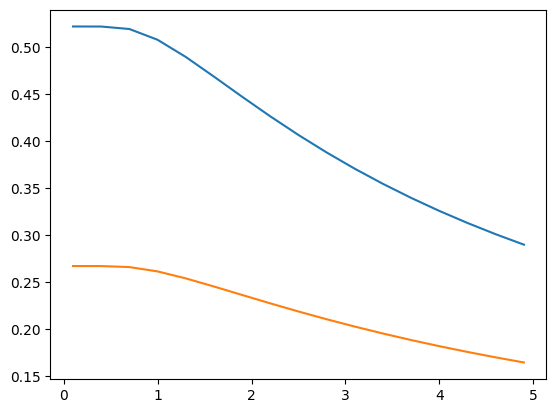

The best alpha is 1 for feline and 1 for cheetah


In [15]:
# Test different hyperparameters:
# Test alpha:
improvement_cheetah = []
improvement_feline = []
for alpha in np.arange(0.1, 5.1, 0.3):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = alpha, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    print(f'Alpha is {alpha:.1f}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])

# Plot the results:
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_cheetah, label = 'cheetah')
plt.plot(np.arange(0.1, 5.1, 0.3), improvement_feline, label = 'feline')
plt.show()
print(f"The best alpha is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Beta is 1
Similarity is changed by 0.2336 between cat and feline
Similarity is changed by 0.4403 between cat and cheetah
Beta is 2
Similarity is changed by 0.2617 between cat and feline
Similarity is changed by 0.5079 between cat and cheetah
Beta is 3
Similarity is changed by 0.2665 between cat and feline
Similarity is changed by 0.5200 between cat and cheetah
Beta is 4
Similarity is changed by 0.2672 between cat and feline
Similarity is changed by 0.5217 between cat and cheetah
Beta is 5
Similarity is changed by 0.2673 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 6
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 7
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 8
Similarity is changed by 0.2674 between cat and feline
Similarity is changed by 0.5220 between cat and cheetah
Beta is 9
Similarity is changed 

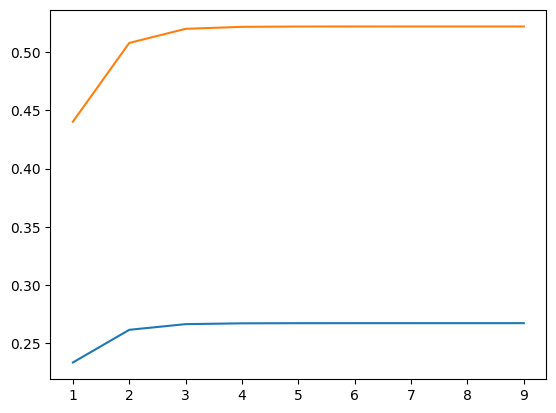

The best beta is 9 for feline and 9 for cheetah


In [14]:
# Test beta:
improvement_feline = []
improvement_cheetah = []
for beta in range(1, 10):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = 10, alpha = 1, beta = beta)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Beta is {beta}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 10), improvement_feline, label = 'feline')
plt.plot(range(1, 10), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best beta is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")

Number of iterations is 1
Similarity is changed by 0.2487 between cat and feline
Similarity is changed by 0.4857 between cat and cheetah
Number of iterations is 2
Similarity is changed by 0.2562 between cat and feline
Similarity is changed by 0.4971 between cat and cheetah
Number of iterations is 3
Similarity is changed by 0.2588 between cat and feline
Similarity is changed by 0.5019 between cat and cheetah
Number of iterations is 4
Similarity is changed by 0.2601 between cat and feline
Similarity is changed by 0.5044 between cat and cheetah
Number of iterations is 5
Similarity is changed by 0.2607 between cat and feline
Similarity is changed by 0.5058 between cat and cheetah
Number of iterations is 6
Similarity is changed by 0.2611 between cat and feline
Similarity is changed by 0.5067 between cat and cheetah
Number of iterations is 7
Similarity is changed by 0.2614 between cat and feline
Similarity is changed by 0.5072 between cat and cheetah
Number of iterations is 8
Similarity is c

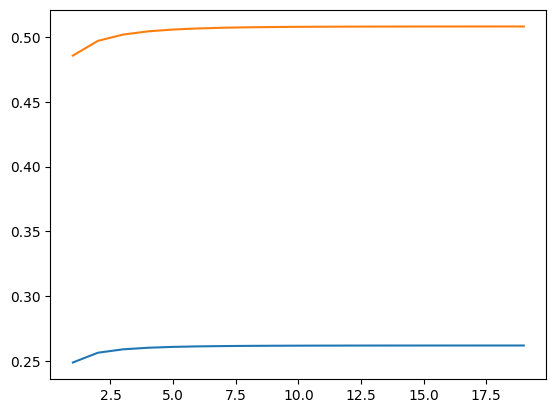

The best number of Iteration is 19 for feline and 19 for cheetah


In [16]:
# Test number of iterations:
improvement_feline = []
improvement_cheetah = []
for iter in range(1, 20):
    newWordVecs = retrofit(toy_wordVecs, lexicon, numIters = iter, alpha = 1, beta = 2)
    retro_similarity_matrix = np.zeros((len(vec_toy_corpus), len(vec_toy_corpus)))
    for i in range(len(vec_toy_corpus)):
        for j in range(len(vec_toy_corpus)):
            retro_similarity_matrix[i][j] = cosine_similarity(newWordVecs[toy_corpus[i]], newWordVecs[toy_corpus[j]])
    improvement_feline.append(retro_similarity_matrix[3][6] - similarity_matrix[3][6])
    improvement_cheetah.append(retro_similarity_matrix[3][4] - similarity_matrix[3][4])
    print(f'Number of iterations is {iter}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][6] - similarity_matrix[3][6]:.4f} between {toy_corpus[3]} and {toy_corpus[6]}')
    print(f'Similarity is changed by {retro_similarity_matrix[3][4] - similarity_matrix[3][4]:.4f} between {toy_corpus[3]} and {toy_corpus[4]}')

# Plot the results:
plt.plot(range(1, 20), improvement_feline, label = 'feline')
plt.plot(range(1, 20), improvement_cheetah, label = 'cheetah')
plt.show()
print(f"The best number of Iteration is {np.argmax(improvement_feline) + 1} for feline and {np.argmax(improvement_cheetah) + 1} for cheetah")